# Malaria Detection

## Problem Definition
### The context:
Why is this problem important to solve?
- Malaria a contagious disease caused by Plasmodium parasites that are transmitted to humans through the bites of infected female Anopheles mosquitoes
- Damage red blood cells (RBCs) which results in respiratory distress and other complications
- Parasites can stay alive for more than a year without any symptoms
- Late treatment causes complications
- More than 50% of the population in danger, some data from 2019:
    - More than 229 million cases
    - 400,000 deaths
    - 67% of deaths were children under 5 years of age
- Challenges
    - Diagnosis in a lab requires careful inspection by an experienced professional to discriminate between healthy and  infected red blood cells.
    - Tedious and time consuming process
    - Diagnostic accuracy (which heavily depends on human expertise) can be adversely impacted by inter observer variability.
- Scope of Innovation
    - An automated system can help with the early and accurate detection of malaria.
    - Automated classification using AI/ML have higher accuracy than manual classification.
    - Would be highly beneficial to propose a method that detects malaria using Deep Learning Algorithms.

### The objectives:
What is the intended goal?
- Build an efficient computer vision model to detect malaria.
- The model should identify whether the image of an RBC is Parasitized or uninfected

### The key questions:
What are the key questions that need to be answered?<br>
- Can a model successfully classify parasitized cells and uninfected cells trained on the provided dataset of RBC images?
- Can we optimize the model to rule out false negatives? As false negatives can be mission critical to patients’ life.

### The problem formulation:
What is it that we are trying to solve using data science?
- Design a computer vision model trained on the given dataset of RBC images which should be able to detect malaria at an earlier stage. The model should be optimized to reduce false negatives, so that it does not miss anyone infected while keeping the cost of the model as low as possible.


## Mounting the Drive

In [52]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading libraries

In [53]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import random
from random import shuffle

from abc import ABC, abstractmethod

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

import logging

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

## Let us load the data

In [54]:
class Data():
    SIZE = 64
    def __init__(self, zip_path, train_dir, test_dir, classifiers):
        
        self.classifiers = classifiers
        self._unzip(zip_path)
        
        print("\n\nReading RGB training data")
        self.train_images, self.train_labels = self._read_data(dir_to_read_from = train_dir, data_title = 'train data')
        print("\nTask Complete")

        print("\n\nReading RGB test data")
        self.test_images, self.test_labels = self._read_data(dir_to_read_from = test_dir, data_title = 'test data')
        print("\nTask Complete")
        
        print("\n\nNormalizing RGB training data")
        self.train_images = self._normalize_images(images_list = self.train_images)
        print("\nTask Complete")

        print("\n\nNormalizing RGB test data")
        self.test_images = self._normalize_images(images_list = self.test_images)
        print("\nTask Complete")
        
        print("\n\nGenerating HSV training data")
        self.train_images_hsv = self._convert_to_hsv(images_list = self.train_images)
        print("\nTask Complete")

        print("\n\nGenerating HSV test data")
        self.test_images_hsv = self._convert_to_hsv(images_list = self.test_images)
        print("\nTask Complete")
        
        print("\n\nGenerating 1 hot encoing for train labels")
        self.train_labels_1hotencoded = self._one_hot_encoding(labels_list = self.train_labels, classifiers = self.classifiers)
        print("\nTask Complete")

        print("\n\nGenerating 1 hot encoing for test labels")
        self.test_labels_1hotencoded = self._one_hot_encoding(labels_list = self.test_labels, classifiers = self.classifiers)
        print("\nTask Complete")
        
        print("\n\nGenerating augmented data for RGB training set")
        self.train_generator, self.val_generator = self._augment_data(self.train_images, self.train_labels_1hotencoded)
        print("\nTask Complete")

        print("\n\nGenerating augmented data for HSV training set")
        self.train_generator_hsv, self.val_generator_hsv = self._augment_data(self.train_images_hsv, self.train_labels_1hotencoded)
        print("\nTask Complete")

        print("\n\nGenerating bigger images for algorithm which needs bigger sized images for RGB training set")
        self.train_images_increased_size = self._increase_image_size(75, self.train_images)
        print("\nTask Complete")

        print("\n\nGenerating bigger images for algorithm which needs bigger sized images for RGB test set")
        self.test_images_increased_size = self._increase_image_size(75, self.test_images)
        print("\nTask Complete")
        
        print("\n\nGenerating bigger images for algorithm which needs bigger sized images for HSV training set")
        self.train_images_hsv_increased_size = self._convert_to_hsv(images_list = self.train_images_increased_size)
        print("\nTask Complete")

        print("\n\nGenerating bigger images for algorithm which needs bigger sized images for HSV test set")
        self.test_images_hsv_increased_size = self._convert_to_hsv(images_list = self.test_images_increased_size)
        print("\nTask Complete")
        
        print("\n\nGenerating augmented data for bigger images for algorithm which needs bigger sized images for RGB training set")
        self.train_generator_increased_size, self.val_generator_increased_size = self._augment_data(self.train_images_increased_size, self.train_labels_1hotencoded)
        print("\nTask Complete")

        print("\n\nGenerating augmented data for bigger images for algorithm which needs bigger sized images for HSV training set")
        self.train_generator_hsv_increased_size, self.val_generator_hsv_increased_size = self._augment_data(self.train_images_hsv_increased_size, self.train_labels_1hotencoded)
        print("\nTask Complete")
        
    def _unzip(self, zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall()
    
    def _read_data(self, dir_to_read_from, data_title):
        images_list = []
        labels_list = []
        for idx, classifier in enumerate(self.classifiers):
            folder_path = "/" + classifier + "/"
            images_path = os.listdir(dir_to_read_from + folder_path)
            
            for i, image_name in enumerate(images_path):
                try:
                    image = Image.open(dir_to_read_from + folder_path + image_name)
                    image = image.resize((Data.SIZE, Data.SIZE))
                    images_list.append(np.array(image))
                    labels_list.append(idx)
                except Exception:
                    pass

        np_image_list = np.array(images_list)
        np_label_list = np.array(labels_list)

        self.print_info(np_image_list, np_label_list, data_title)

        return (np_image_list, np_label_list)

    def print_info(self, images, labels, data_title):
        print("\n\nInformation about " + data_title)

        print("\n")

        print(data_title + " images shape: ", images.shape)
        print(data_title + " labels shape: ", labels.shape)

        print("\n")
    
        print(data_title + " min pixel value:", images.min())
        print(data_title + " max pixel value:", images.max())
    
    def _normalize_images(self, images_list):
        images_list = (images_list/255).astype('float32')
        return images_list
    
    def _augment_data(self, train_images, train_labels):
        np.random.seed(42)
        random.seed(42)
        tf.random.set_seed(42)
        X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
        train_datagen = ImageDataGenerator(
                                    horizontal_flip=True, 
                                    shear_range=0.2,
                                    zoom_range = 0.2, 
                                    rotation_range=20)
        val_datagen  = ImageDataGenerator()
        train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size=64, seed=42, shuffle=True)
        val_generator =  val_datagen.flow(x= X_val, y = y_val, batch_size=64, seed=42, shuffle=True)
        return (train_generator, val_generator)
        
    def _convert_to_hsv(self, images_list):
        hsv_image_list = []
        for img in images_list:
            hsv_image_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
        return np.array(hsv_image_list)

    def _one_hot_encoding(self, labels_list, classifiers):
        labels_list=to_categorical(labels_list, len(classifiers))
        return labels_list

    def _increase_image_size(self, new_size, images):
        return np.array([cv2.resize(image, (new_size, new_size), interpolation = cv2.INTER_CUBIC) for image in images])


    def visualize_data(self, images, labels, classifiers, rows, cols, title):
        print('Shape of ' + title)
        print(images.shape)
        print('Some images from ' + title)
        np.random.seed(42)
        total = rows*cols
        plt.figure(1 , figsize = (total , total))
        logger = logging.getLogger()
        old_level = logger.level
        logger.setLevel(100)
        for n in range(1, total+1):
            plt.subplot(rows, cols, n)
            index = int(np.random.randint(0, images.shape[0], 1))
            plt.title(classifiers[labels[index]])
            plt.imshow(images[index])
            plt.axis('off')
        logger.setLevel(old_level)

    def plot_data_to_check_balance(self, labels, classifiers, title):
        print('Checking balance of ' + title)
        df_labels = pd.DataFrame(labels, columns = ['classifiers'])
        print(df_labels.value_counts())
        sns.set_theme(style="darkgrid")
        plt.title("Checking data balance for " + title)
        sns.countplot(x="classifiers", data=df_labels)
        plt.show()
        
    def print_mean_img(self, classifiers, images, labels, data_title):
        print('Mean images for ' + data_title)
        image_data_for_each_classifier = {}
        for idx, classifier in enumerate(classifiers):
            image_data_for_each_classifier[idx] = []
        
        for img, label in zip(images, labels):
            image_data_for_each_classifier[label].append([img])
        
        for title_idx, corresponding_images in image_data_for_each_classifier.items():
            full_mat = np.array(corresponding_images)
            title = classifiers[title_idx]
            mean_img = np.mean(full_mat, axis = 0)[0]
            plt.imshow(mean_img)
            plt.title(f'Average {title}')
            plt.axis('off')
            plt.show()

    def gaussian_blur(self, images, labels, data_title):
        print('Gaussian blur images for ' + data_title)
        gbx=[]  ## to hold the blurred images
        for i in np.arange(0,100,1):
            b= cv2.GaussianBlur(images[i], (5, 5), 0)
            gbx.append(b)
        gbx=np.array(gbx)

        viewimage=np.random.randint(1,100,5)
        fig,ax=plt.subplots(1,5,figsize=(18,18))
        for t,i in zip(range(5),viewimage):
            Title=labels[i]
            ax[t].set_title(Title)
            ax[t].imshow(gbx[i])
            ax[t].set_axis_off()
            fig.tight_layout()

In [55]:
data = Data (
            zip_path = '/content/drive/MyDrive/MIT/Notebooks/Capstone Project/cell_images.zip', 
            train_dir = '/content/cell_images/train', 
            test_dir = '/content/cell_images/test', 
            classifiers = ['uninfected','parasitized'])




Reading RGB training data


Information about train data


train data images shape:  (24958, 64, 64, 3)
train data labels shape:  (24958,)


train data min pixel value: 0
train data max pixel value: 255

Task Complete


Reading RGB test data


Information about test data


test data images shape:  (2600, 64, 64, 3)
test data labels shape:  (2600,)


test data min pixel value: 0
test data max pixel value: 255

Task Complete


Normalizing RGB training data

Task Complete


Normalizing RGB test data

Task Complete


Generating HSV training data

Task Complete


Generating HSV test data

Task Complete


Generating 1 hot encoing for train labels

Task Complete


Generating 1 hot encoing for test labels

Task Complete


Generating augmented data for RGB training set

Task Complete


Generating augmented data for HSV training set

Task Complete


Generating bigger images for algorithm which needs bigger sized images for RGB training set

Task Complete


Generating bigger images for algorith

## Data Description

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>

The files have been extracted to the local session of Google Colab. The extracted folder would have the following structure:

Folder_Structure.PNG

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images is scaled to 64x64 and are converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we have created the labels for both types of images to be able to train and test the model. 

### <font color=red>Important thing to notice - we have read all our data in the variables of this Data class:</font>
![dataclass]( 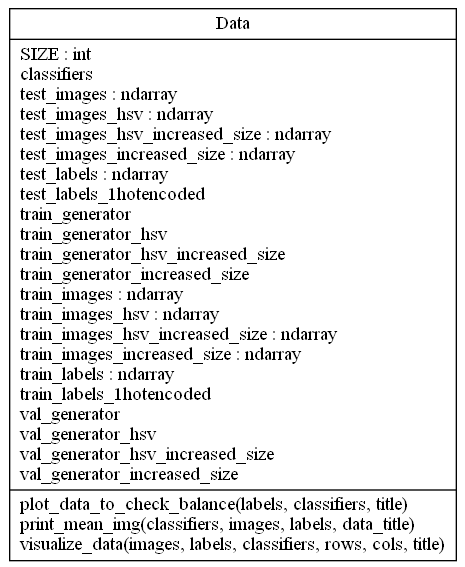)

## Visualizing training data

Shape of train data
(24958, 64, 64, 3)
Some images from train data


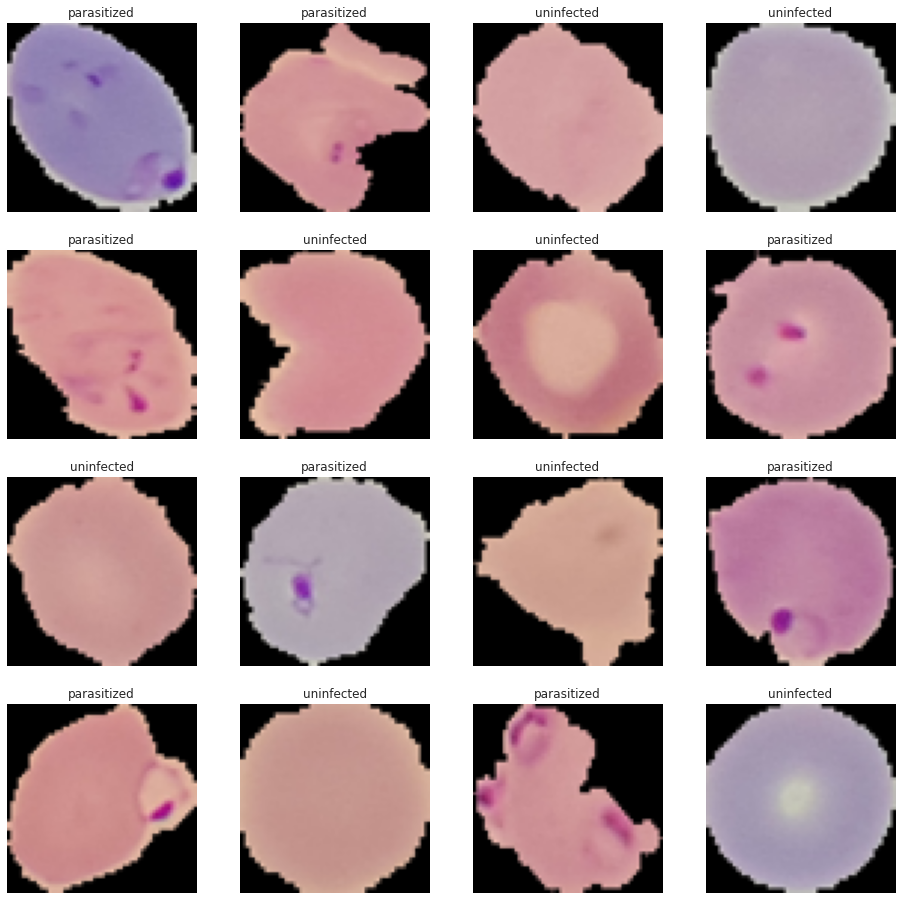

In [56]:
data.visualize_data(images = data.train_images, labels = data.train_labels, classifiers = data.classifiers, rows = 4, cols = 4, title = 'train data')

### Observations from training data

- Data is read in numpy arrays train_images and train_labels:
    - If image is read from parasitized folder under train, corresponding label = 1 is added to train_label array
    - If image is read from uninfected folder under train, corresponding label = 0 is added to train_label array

- train_images (4D array):
    - shape: (24958, 64, 64, 3)
    - 24958 images
    - Image pixel size: 64x64
    - Image depth: 3 (RGB representation of each pixel)

- train_labels (1D array):
    - shape: (24958, )
    - 24958 labels
    - each label corresponding to each image in the train_images array

## Visulaizing test data

Shape of test data
(2600, 64, 64, 3)
Some images from test data


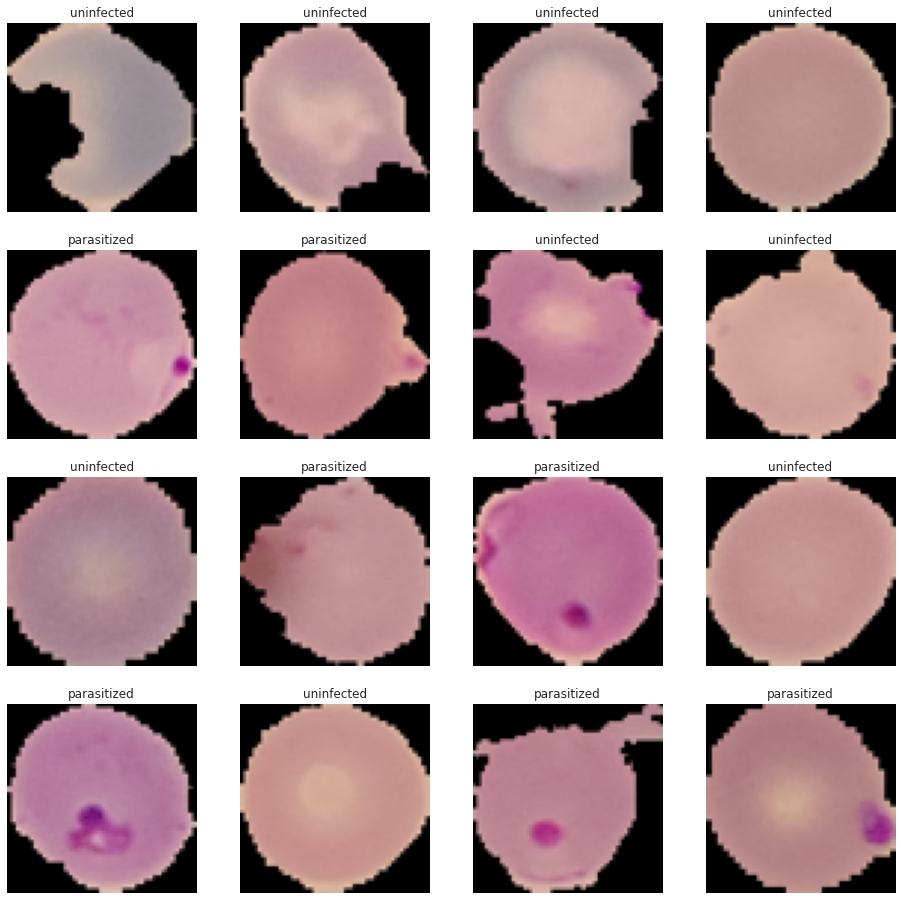

In [57]:
data.visualize_data(images = data.test_images, labels = data.test_labels, classifiers = data.classifiers, rows = 4, cols = 4, title = 'test data')

### Observations from test data

- Data is read in numpy arrays test_images and test_labels:
    - If image is read from parasitized folder under test, corresponding label = 1 is added to test_label array
    - If image is read from uninfected folder under test, corresponding label = 0 is added to test_label array

- test_images (4D array):
    - shape: (2600, 64, 64, 3)
    - 2600 images
    - Image pixel size: 64x64
    - Image depth: 3 (RGB representation of each pixel)

- test_labels (1D array):
    - shape: (2600, )
    - 2600 labels
    - each label corresponding to each image in the test_images array

### Overall observations looking at the images from train and test data
- Weather parasitized or uninfected, all images have dark areas in all four corners of the image
- It seems the uninfected cells have uniform color in the cell image
- Parasitized cells have patches of another color inside the cell image.
- Sometimes uninfected cells have a wide ring of the same color we have patches on parasitized cells. We should extract this feature to rule out any false positives, if cell color is not uniform.
- Cell seems to occupy the center of the making a (imperfect) circle (mostly). Sometimes its random shaped cell as well.

## Data balance for training data

In [58]:
data.plot_data_to_check_balance(labels = data.train_labels, classifiers = data.classifiers, title = 'train data')

Checking balance of train data
classifiers
1              12582
0              12376
dtype: int64


### Observations about data balance for training data

- Data distribution for train data:
    - Records that are parasitized: 12582
    - Records that are uninfected: 12376
    
- Data is well balanced in training data (helps with unbiased model creation)

## Data balance for test data

Checking balance of test data
classifiers
0              1300
1              1300
dtype: int64


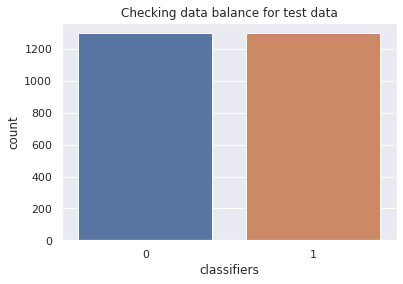

In [59]:
data.plot_data_to_check_balance(labels = data.test_labels, classifiers = data.classifiers, title = 'test data')

### Observations about data balance for test data
    
- Data distribution for test data:
    - Records that are parasitized: 1300
    - Records that are uninfected: 1300

- Data is well balanced in test data (helps with unbiased model creation)

## Mean Image for training and test data

Lets have a look at the mean images if both training and test data

Mean images for train data


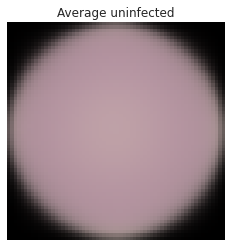

In [60]:
data.print_mean_img(classifiers = data.classifiers, images = data.train_images, labels = data.train_labels, data_title = 'train data')

Mean images for test data


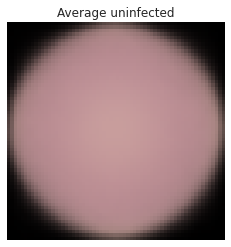

In [61]:
data.print_mean_img(classifiers = data.classifiers, images = data.test_images, labels = data.test_labels, data_title = 'test data')

### Observations from mean Image for both training and test data

- Mean image for parasitized data 
	- It has a circle in the center representing the cell
	- The corners of the image seems to have empty dark space.
	- There seems to be uniform color for the cell
	- The color is slightly darker at the circle perimeter (which most probably is due to the contribution from the dark space outside the circle)
- Mean image for uninfected data
	- It has a circle in the center representing the cell
	- The corners of the image seems to have empty dark space.
	- The color is slightly darker at the circle perimeter (which most probably is due to the contribution from the dark space outside the circle)


## Data Normalization:

- Normalization makes the training faster and reduces the chances of getting stuck at local optima.
- Also, weight decay and estimation can be done more conveniently with normalized inputs.
- It helps to avoid exploding gradient problems. Gradient exploding problem occurs when large error gradients accumulate and result in very large updates to neural network model weights during training. This makes a model unstable and unable to learn from the training data.

In [62]:
# We have already normalized data after reading it in our Data class
data.print_info(data.train_images, data.train_labels, '')
data.print_info(data.test_images, data.test_labels, '')



Information about 


 images shape:  (24958, 64, 64, 3)
 labels shape:  (24958,)


 min pixel value: 0.0
 max pixel value: 1.0


Information about 


 images shape:  (2600, 64, 64, 3)
 labels shape:  (2600,)


 min pixel value: 0.0
 max pixel value: 1.0


### Observations for data normalization:

- As both train data images and test data images have pixel value ranging from 0 to 255, we have normalized those values by dividing them by 255. So, now all values lie between 0 and 1 and their data type has changed from integer to floating point number.

- Old value range:
	- test_images min pixel value: 0
	- test_images max pixel value: 255
	- train_images min pixel value: 0
	- train_images max pixel value: 255
- New value range after normalization:
	- test_images min pixel value: 0
	- test_images max pixel value: 1.0
	- train_images min pixel value: 0
	- train_images max pixel value: 1.0

## RGB to HSV

- Converting images from RGB to HSV helps with separating luma, or the image intensity, from chroma or the color information. This is very useful in our current scenario for feature extraction.
- To determine the patches of a different color in parasitized cells, we would want to get rid of the intensity component and we will be able to determine if there is another color patch on the cell.

In [11]:
data.visualize_data(images = data.train_images_hsv, labels = data.train_labels, classifiers = data.classifiers, rows = 4, cols = 4, title = 'train data')

Shape of train data
(24958, 64, 64, 3)
Some images from train data


In [12]:
data.visualize_data(images = data.test_images_hsv, labels = data.test_labels, classifiers = data.classifiers, rows = 4, cols = 4, title = 'test data')

Shape of test data
(2600, 64, 64, 3)
Some images from test data


### Observations from HSV data

- HSV data seems to highlight clearly whenever there is a patch on the cell. And it can easily be determined whether the cell is paracitized or not.
- We sholld run HSV data along with RGB data through our models and see which one performs better.

## Different types of data that we will be using to train our models 

### Classes to organize data
- We have four different types of data:
    - RGB Data
    - RGB Data with Data Augmentation
    - HSV Data
    - HSV Data with Data Augmentation

- We have created following **class heirarchy** to encapsulate our functionality (Sub points are corresponding child classes under the parent class):
    - <font color='red'>ModelData</font> (has info about classifiers and one hot encoded test labels)
        - <font color='blue'>RgbDataBase</font> (has info about RGB test images)
            - <font color='green'>RgbData</font> (has info about RGB train images)
            - <font color='green'>RgbAugmentedData</font> (has info about RGB augmented data train images)
        - <font color='blue'>HsvDataBase</font> (has info about HSV test images)
            - <font color='green'>HsvData</font> (has info about HSV train images)
            - <font color='green'>HsvAugmentedData</font> (has info about HSV augmented data train images)
- **NOTE**: These classes only contain references to data which is our original Data class. This ensures, we are not duplicating data
- The classes are  is depicted in the following class diagram:
![modeldata]( 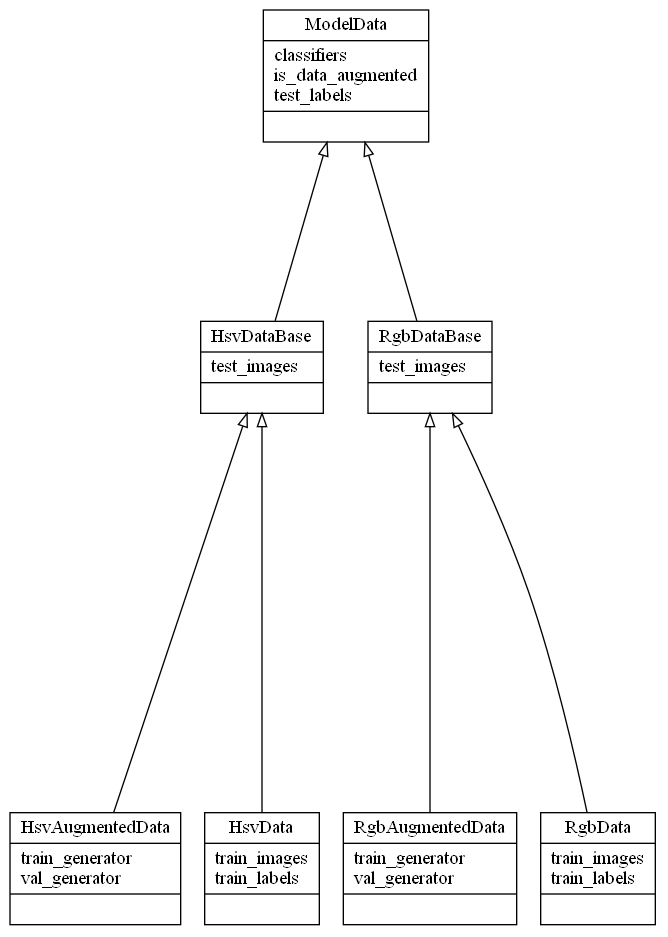)


In [13]:
class ModelData(ABC):
    def __init__(self, data, is_data_augmented):
        self.classifiers = data.classifiers
        self.test_labels = data.test_labels_1hotencoded
        
        # This will be used while deciding weather to use plain data or image generator data while we fit the model
        self.is_data_augmented = is_data_augmented

In [14]:
class RgbDataBase(ModelData):
    def __init__(self, data, is_increased_size_required = False, is_data_augmented = False):
        if (is_increased_size_required == False):
            self.test_images = data.test_images
        else:
            self.test_images = data.test_images_increased_size
        ModelData.__init__(self, data, is_data_augmented)

In [15]:
class RgbData(RgbDataBase):
    def __init__(self, data, is_increased_size_required = False):
        if (is_increased_size_required == False):
            self.train_images = data.train_images
        else:
            self.train_images = data.train_images_increased_size
        self.train_labels = data.train_labels_1hotencoded
        RgbDataBase.__init__(self, data, is_increased_size_required, False)

In [16]:
class RgbAugmentedData(RgbDataBase):
    def __init__(self, data, is_increased_size_required = False):
        if (is_increased_size_required == False):
            self.train_generator = data.train_generator
            self.val_generator = data.val_generator
        else:
            self.train_generator = data.train_generator_increased_size
            self.val_generator = data.val_generator_increased_size
        RgbDataBase.__init__(self, data, is_increased_size_required, True)

In [17]:
class HsvDataBase(ModelData):
    def __init__(self, data, is_increased_size_required = False, is_data_augmented = False):
        if (is_increased_size_required == False):
            self.test_images = data.test_images_hsv
        else:
            self.test_images = data.test_images_hsv_increased_size
        ModelData.__init__(self, data, is_data_augmented)

In [18]:
class HsvData(HsvDataBase):
    def __init__(self, data, is_increased_size_required = False):
        if (is_increased_size_required == False):
            self.train_images = data.train_images_hsv
        else:
            self.train_images = data.train_images_hsv_increased_size
        self.train_labels = data.train_labels_1hotencoded
        HsvDataBase.__init__(self, data, is_increased_size_required, False)

In [19]:
class HsvAugmentedData(HsvDataBase):
    def __init__(self, data, is_increased_size_required = False):
        if (is_increased_size_required == False):
            self.train_generator = data.train_generator_hsv
            self.val_generator = data.val_generator_hsv
        else:
            self.train_generator = data.train_generator_hsv_increased_size
            self.val_generator = data.val_generator_hsv_increased_size
        HsvDataBase.__init__(self, data, is_increased_size_required, True)

In [20]:
rgbData = RgbData(data)
rgbAugmentedData = RgbAugmentedData(data)
hsvData = HsvData(data)
hsvAugmentedData = HsvAugmentedData(data)

## Different types of models that we will have 

### Classes to organize models definitions
- We have five different types of model definitions:
    - Base Model
    - Model With Leaky Relu
    - Model With Leaky Relu and Batch Normalization
    - Model With Transfer Learning using VGG16
    - Model With Transfer Learning using Inception V3

- We have created following **class heirarchy** to encapsulate our models functionality (Sub points are corresonding child classes under the parent class):
    - <font color='red'>AbstractModel</font> (defines methods for how models will be executed - common across all models)
        - <font color='blue'>BaseModel</font> (defines model definition and sets model data for Base Model)
        - <font color='blue'>ModelWithLeakyRelu</font> (defines model definition and sets model data for Model With Leaky Relu)
        - <font color='blue'>ModelWithLeakyReluBatchNormalization</font> (defines model definition and sets model data for Model With Leaky Relu and Batch Normalization)
        - <font color='blue'>ModelWithTransferLearningVGG16</font> (defines model definition and sets model data for Model With Transfer Learning using VGG16)
        - <font color='blue'>ModelWithTransferLearningInceptionV3</font> (defines model definition and sets model data for Model With Transfer Learning using Inception V3)

- The classes are  is depicted in the following class diagram:
![modelclasses]( 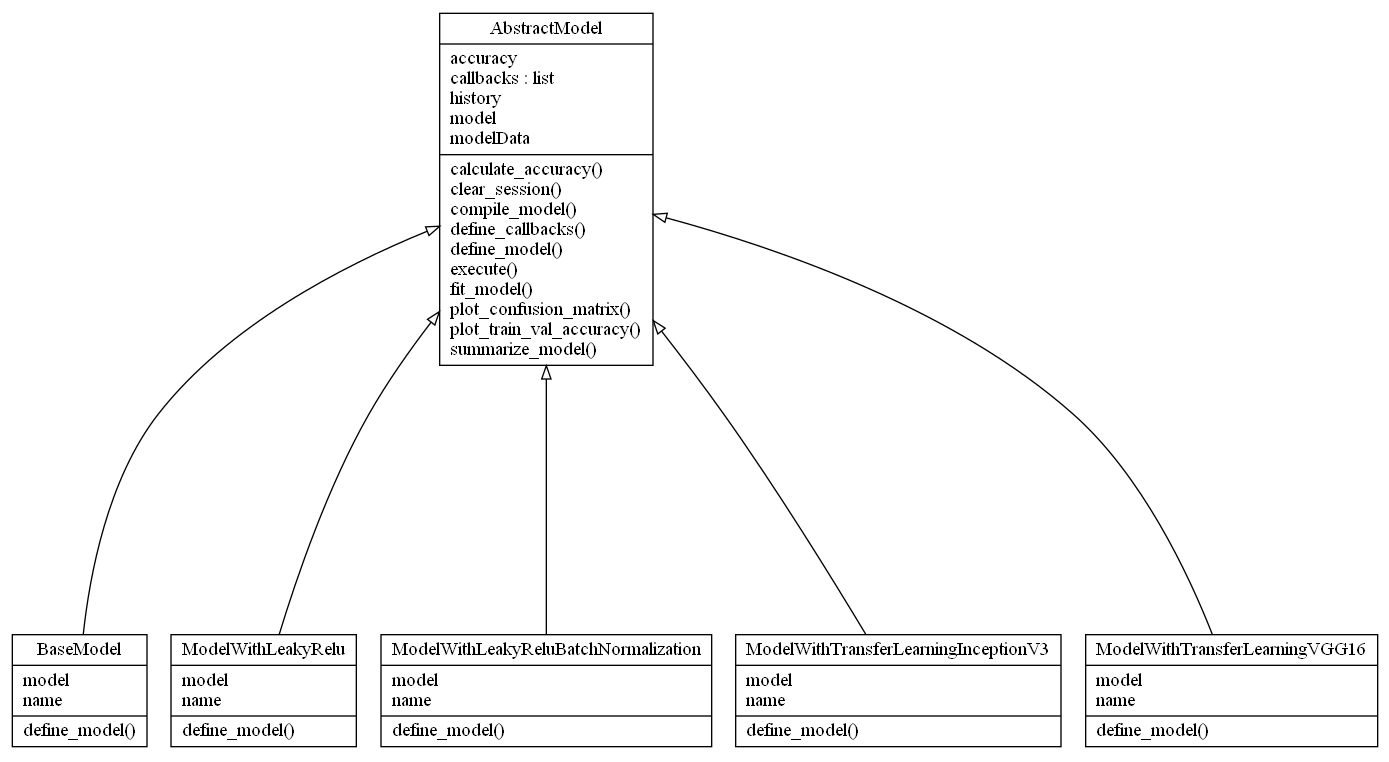)


### Models definition and model data permutations for form final models
- We have 4 different types of data:
    - RGB Data
    - RGB Data with Data Augmentation
    - HSV Data
    - HSV Data with Data Augmentation
- We have 5 different types of model definitions:
    - Base Model
    - Model With Leaky Relu
    - Model With Leaky Relu and Batch Normalization
    - Model With Transfer Learning using VGG16
    - Model With Transfer Learning using Inception V3
    
### <font color='red'>To train final models we will be training each of the 5 model definitions with 4 different types of data separately. That will give us 4x5 = 20 different types of models.</font>
- Base Model <font color='red'> | </font> RGB Data
- Base Model <font color='red'> | </font> RGB Data with Data Augmentation
- Base Model <font color='red'> | </font> HSV Data
- Base Model <font color='red'> | </font> HSV Data with Data Augmentation
- Model With Leaky Relu <font color='red'> | </font> RGB Data
- Model With Leaky Relu <font color='red'> | </font> RGB Data with Data Augmentation
- Model With Leaky Relu <font color='red'> | </font> HSV Data
- Model With Leaky Relu <font color='red'> | </font> HSV Data with Data Augmentation
- Model With Leaky Relu and Batch Normalization <font color='red'> | </font> RGB Data
- Model With Leaky Relu and Batch Normalization <font color='red'> | </font> RGB Data with Data Augmentation
- Model With Leaky Relu and Batch Normalization <font color='red'> | </font> HSV Data
- Model With Leaky Relu and Batch Normalization <font color='red'> | </font> HSV Data with Data Augmentation
- Model With Transfer Learning using VGG16 <font color='red'> | </font> RGB Data
- Model With Transfer Learning using VGG16 <font color='red'> | </font> RGB Data with Data Augmentation
- Model With Transfer Learning using VGG16 <font color='red'> | </font> HSV Data
- Model With Transfer Learning using VGG16 <font color='red'> | </font> HSV Data with Data Augmentation
- Model With Transfer Learning using Inception V3 <font color='red'> | </font> RGB Data
- Model With Transfer Learning using Inception V3 <font color='red'> | </font> RGB Data with Data Augmentation
- Model With Transfer Learning using Inception V3 <font color='red'> | </font> HSV Data
- Model With Transfer Learning using Inception V3 <font color='red'> | </font> HSV Data with Data Augmentation

## AbstractModel class for performing common functions

- execute method sequentially calls:
    - clear_session() - for clearing session
    - define_model() - child class defines the model definition
    - summarize_model() - summary of the model
    - compile_model() - compiles the model
    - define_callbacks() - defines callbacks, once model achieves certain accuracy, it stops further training
    - fit_model() - actual training of the models
    - calculate_accuracy() - calculates the accuracy of the model
    - plot_confusion_matrix() - plots the confusion matrix 
    - plot_train_val_accuracy() - plots the training v/s validation graph

In [21]:
class AbstractModel(ABC):

    def __init__(self, model, modelData):
        self.model = model
        self.modelData = modelData

    def execute(self):
        self.clear_session()
        self.define_model()
        self.summarize_model()
        self.compile_model()
        self.define_callbacks()
        self.fit_model()        
        self.calculate_accuracy()
        self.plot_confusion_matrix()
        self.plot_train_val_accuracy()

    def clear_session(self):
        backend.clear_session()
        np.random.seed(42)
        random.seed(42)
        tf.random.set_seed(42)
    
    @abstractmethod
    def define_model(self):
        pass

    def summarize_model(self):
        self.model.summary()
    
    def compile_model(self):
        adam = optimizers.Adam(learning_rate=0.001)
        self.model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    def define_callbacks(self):
        self.callbacks = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

    def fit_model(self):
        if (self.modelData.is_data_augmented):
            self.history = self.model.fit(self.modelData.train_generator, validation_data=self.modelData.val_generator, batch_size=32,callbacks=self.callbacks, epochs=20,verbose=1)
        else:
            self.history = self.model.fit(self.modelData.train_images, self.modelData.train_labels, batch_size=32, callbacks=self.callbacks, validation_split=0.2, epochs=20, verbose=1)

    def calculate_accuracy(self):
        print('\n', 'Calculating Accuracy:')
        self.accuracy = self.model.evaluate(self.modelData.test_images, self.modelData.test_labels, verbose=1)
        print('\n', 'Test Accuracy:', self.accuracy[1])
        print('\n')

    def plot_confusion_matrix(self):
        pred = self.model.predict(self.modelData.test_images)
        pred = np.argmax(pred,axis = 1) 
        y_true = np.argmax(self.modelData.test_labels,axis = 1)

        print('\n', 'Classification Report')
        #Printing the classification report
        print(classification_report(y_true,pred))
        
        print('\n\n', 'Confusion Matrix')
        #Plotting the heatmap using confusion matrix
        cm = confusion_matrix(y_true,pred)
        plt.figure(figsize=(8,5))
        sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=self.modelData.classifiers, yticklabels=self.modelData.classifiers)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        print('\n')

    def plot_train_val_accuracy(self):
        print('\n\n Train and Validation Accuracy')
        N = len(self.history.history["accuracy"])
        plt.figure(figsize=(7,7))
        plt.plot(np.arange(0, N), self.history.history["accuracy"], label="train_accuracy", ls='--')
        plt.plot(np.arange(0, N), self.history.history["val_accuracy"], label="val_accuracy", ls='--')
        plt.title("Accuracy vs Epoch")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(loc="upper left")

## Base Model

In [22]:
class BaseModel(AbstractModel):
    def __init__(self, modelData, name):
        self.model = Sequential()
        self.name = name
        AbstractModel.__init__(self, self.model, modelData)

    def define_model(self):
        self.model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
        self.model.add(MaxPooling2D(pool_size=2))
        self.model.add(Dropout(0.2))
        self.model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
        self.model.add(MaxPooling2D(pool_size=2))
        self.model.add(Dropout(0.2))
        self.model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
        self.model.add(MaxPooling2D(pool_size=2))
        self.model.add(Dropout(0.2))
        self.model.add(Flatten())
        self.model.add(Dense(512,activation="relu"))
        self.model.add(Dropout(0.4))
        self.model.add(Dense(len(self.modelData.classifiers),activation="softmax"))


### Base model | RGB data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0





 Train and Validation Accuracy


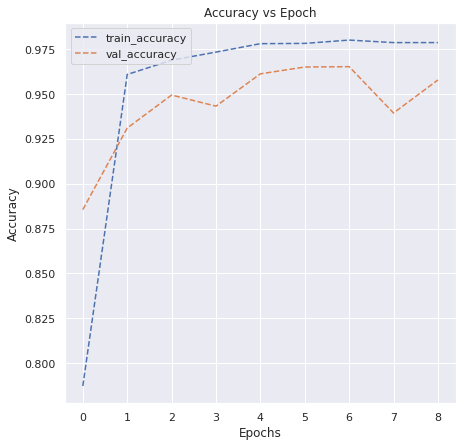

In [23]:
model00 = BaseModel(rgbData, 'Base model | RGB data')
model00.execute()

#### Observations for Base model | RGB data:
- Even with the base model we have got a high accuracy of 0.98. Some other models have higher accuracy.
- False negatives are low. Recall for class 1 is 0.97, which is also quite high. But there are models which are performing better than this model, providing lower false negatives (higher recall score for class 1)
- Validation accuracy line is staying below training accuracy line after epochs=1.


### Base model | RGB data | Data augmentation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0





 Train and Validation Accuracy


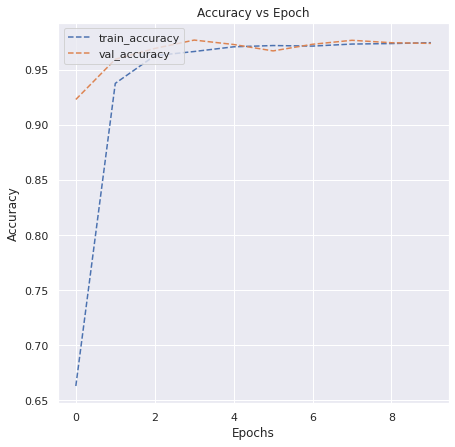

In [24]:
model01 = BaseModel(rgbAugmentedData, 'Base model | RGB data | Data augmentation')
model01.execute()

#### Observations for Base model | RGB data | Data augmentation:

- We have got a high accuracy of 0.98. Some other models have higher accuracy.
- False negatives are low. Recall for class 1 is 0.97, which is also quite high. But there are models which are performing better than this model, providing lower false negatives (higher recall score for class 1)
- Validation accuracy line is staying very close to training accuracy line after epochs=2.


### Base model | HSV data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

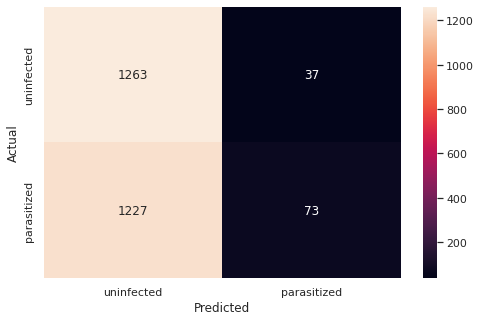





 Train and Validation Accuracy


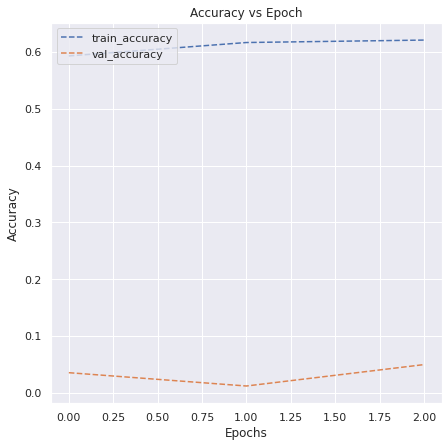

In [25]:
model02 = BaseModel(hsvData, 'Base model | HSV data')
model02.execute()

#### Observations for Base model | HSV data
- Very low accuracy
- Very low recall score for class 1
- Model not useful 


### Base model | HSV data | Data augmentation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

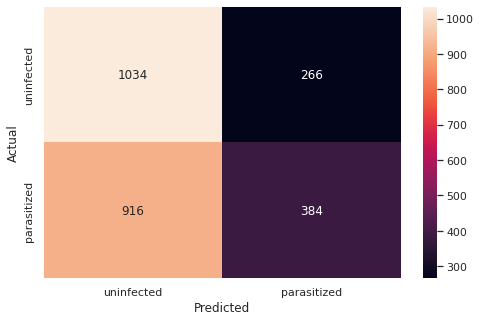





 Train and Validation Accuracy


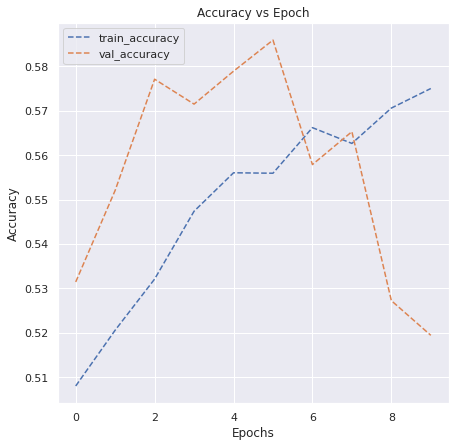

In [26]:
model03 = BaseModel(hsvAugmentedData, 'Base model | HSV data | Data augmentation')
model03.execute()

#### Observations for Base model | HSV data | Data augmentation
- Very low accuracy
- Very low recall score for class 1
- Model not useful 


## Model With Leaky Relu

In [28]:
class ModelWithLeakyRelu(AbstractModel):
    def __init__(self, modelData, name):
        self.model = Sequential()
        self.name = name
        AbstractModel.__init__(self, self.model, modelData)

    def define_model(self):
        self.model.add(Conv2D(filters=32,kernel_size=2,padding="same",input_shape=(64,64,3)))
        self.model.add(LeakyReLU(0.1))
        self.model.add(MaxPooling2D(pool_size=2))
        self.model.add(Dropout(0.2))
        self.model.add(Conv2D(filters=32,kernel_size=2,padding="same"))
        self.model.add(LeakyReLU(0.1))
        self.model.add(MaxPooling2D(pool_size=2))
        self.model.add(Dropout(0.2))
        self.model.add(Conv2D(filters=32,kernel_size=2,padding="same"))
        self.model.add(LeakyReLU(0.1))
        self.model.add(MaxPooling2D(pool_size=2))
        self.model.add(Dropout(0.2))
        self.model.add(Flatten())
        self.model.add(Dense(512))
        self.model.add(LeakyReLU(0.1))
        self.model.add(Dropout(0.4))
        self.model.add(Dense(len(self.modelData.classifiers),activation="softmax"))

### Model With Leaky Relu | RGB data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                        

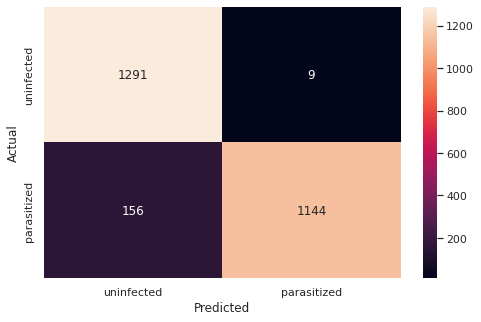





 Train and Validation Accuracy


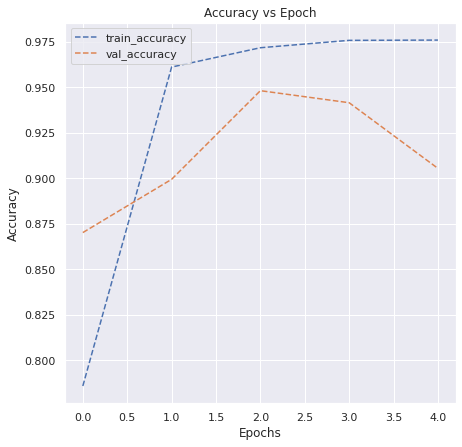

In [ ]:
model10 = ModelWithLeakyRelu(rgbData, 'Model With Leaky Relu | RGB data')
model10.execute()

#### Observations for Model With Leaky Relu | RGB data
- Low recall score of 0.88 for class 1
- Accuracy of 0.94, which is lower than some of the models we have.
- Validation accuracy line is staying below the training accuracy line after epochs = 1.


### Model With Leaky Relu | RGB data | Data augmentation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                        

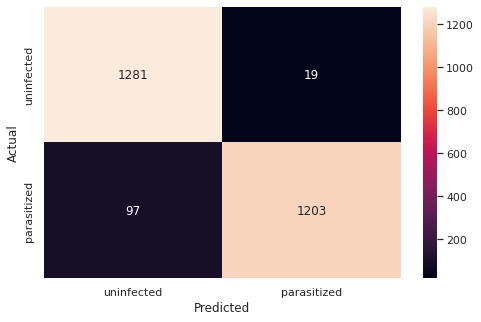





 Train and Validation Accuracy


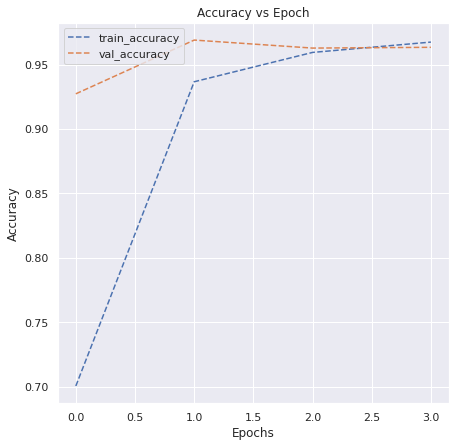

In [ ]:
model11 = ModelWithLeakyRelu(rgbAugmentedData, 'Model With Leaky Relu | RGB data | Data augmentation')
model11.execute()

#### Observations for Model With Leaky Relu | RGB data | Data augmentation
- Recall score of 0.93 for class 1, which is lower than some models
- Accuracy of 0.96, which is lower than some of the models we have.
- Validation accuracy line is getting closer to the training accuracy line after epochs = 1.


### Model With Leaky Relu | HSV data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                        

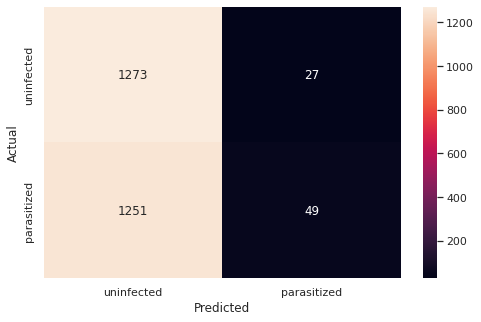





 Train and Validation Accuracy


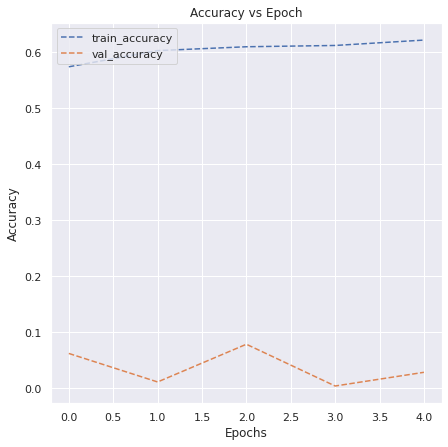

In [29]:
model12 = ModelWithLeakyRelu(hsvData, 'Model With Leaky Relu | HSV data')
model12.execute()

#### Observations for Model With Leaky Relu | HSV data
- Very low accuracy
- Very low recall score for class 1
- Model not useful 


### Model With Leaky Relu | HSV data | Data augmentation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                        

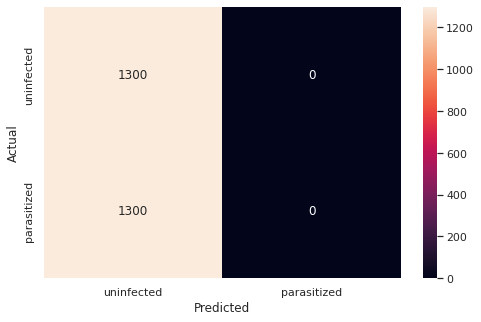





 Train and Validation Accuracy


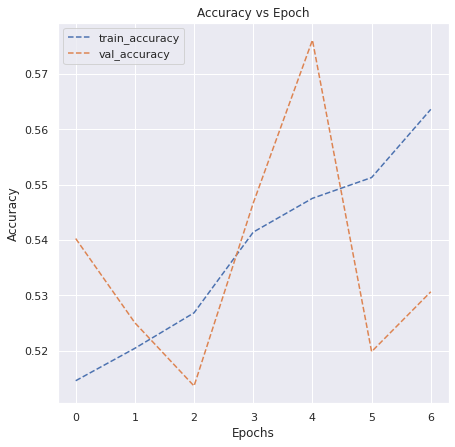

In [ ]:
model13 = ModelWithLeakyRelu(hsvAugmentedData, 'Model With Leaky Relu | HSV data | Data augmentation')
model13.execute()

#### Observations for Model With Leaky Relu | HSV data | Data augmentation
- Very low accuracy
- Very low recall score for class 1
- Model not useful 


## Model With Leaky Relu and Batch Normalization

In [ ]:
class ModelWithLeakyReluBatchNormalization(AbstractModel):
    def __init__(self, modelData, name):
        self.model = Sequential()
        self.name = name
        AbstractModel.__init__(self, self.model, modelData)

    def define_model(self):
        self.model.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding='same'))
        self.model.add(LeakyReLU(0.1))
        self.model.add(MaxPooling2D(pool_size=2))
        self.model.add(Conv2D(filters=32,kernel_size=2,padding="same"))
        self.model.add(LeakyReLU(0.1))
        self.model.add(MaxPooling2D(pool_size=2))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(filters=32,kernel_size=2,padding="same"))
        self.model.add(LeakyReLU(0.1))
        self.model.add(MaxPooling2D(pool_size=2))
        self.model.add(Conv2D(filters=64,kernel_size=2,padding="same"))
        self.model.add(LeakyReLU(0.1))
        self.model.add(MaxPooling2D(pool_size=2))
        self.model.add(BatchNormalization())
        self.model.add(Flatten())
        self.model.add(Dense(512))
        self.model.add(LeakyReLU(0.1))
        self.model.add(Dropout(0.4))
        self.model.add(Dense(len(self.modelData.classifiers),activation="softmax")) 

### Model With Leaky Relu & Batch Normalization | RGB data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

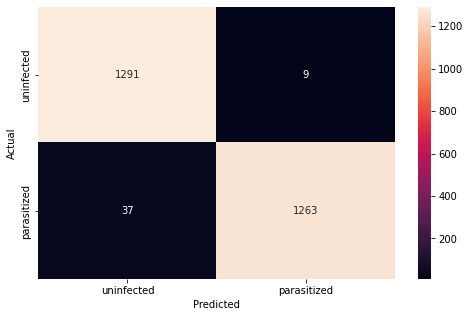





 Train and Validation Accuracy


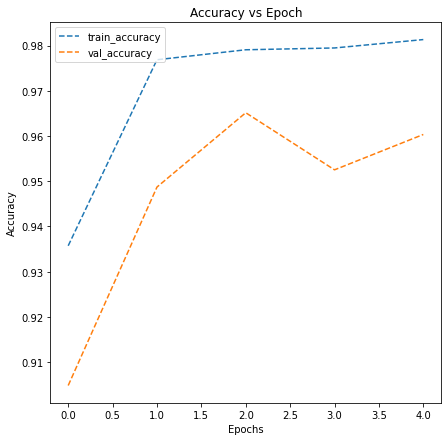

In [ ]:
model20 = ModelWithLeakyReluBatchNormalization(rgbData, 'Model With Leaky Relu & Batch Normalization | RGB data')
model20.execute()

#### Observations for Model With Leaky Relu & Batch Normalization | RGB data
- This model has high accuracy of 0.98.
- It has high recall score of 0.97 for class 1.
- Validation accuracy line is staying above training accuracy line after certain epochs.
- Some other models are better than this.


### Model With Leaky Relu & Batch Normalization | RGB data | Data augmentation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

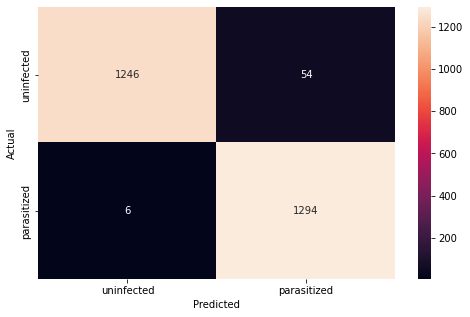





 Train and Validation Accuracy


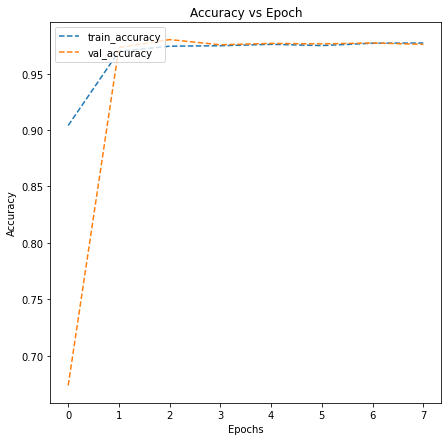

In [ ]:
model21 = ModelWithLeakyReluBatchNormalization(rgbAugmentedData, 'Model With Leaky Relu & Batch Normalization | RGB data | Data augmentation')
model21.execute()

#### Observations for Model With Leaky Relu & Batch Normalization | RGB data | Data augmentation
- This is the best performing model amongst all the models.
- Very high accuracy of 0.98
- Perfect recall score of 1.00. Out of 1300, only 6 are false negative.
- Validation accuracy line is running very close to the training accuracy line after epochs = 1.


### Model With Leaky Relu & Batch Normalization | HSV data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

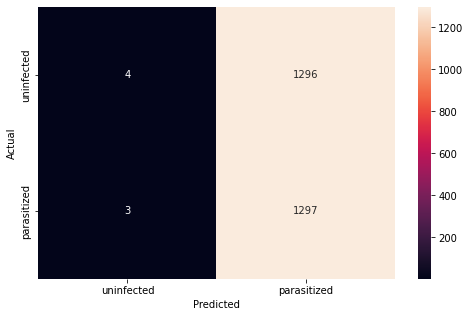





 Train and Validation Accuracy


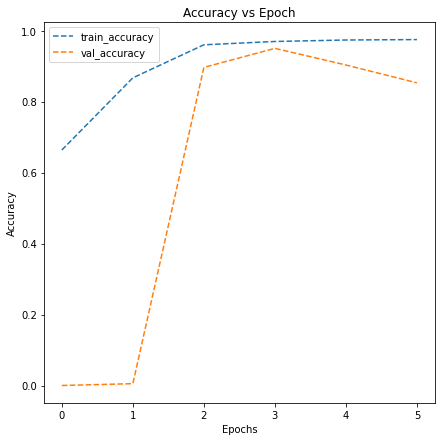

In [ ]:
model22 = ModelWithLeakyReluBatchNormalization(hsvData, 'Model With Leaky Relu & Batch Normalization | HSV data')
model22.execute()

#### Observations for Model With Leaky Relu & Batch Normalization | HSV data
- Very low accuracy
- Very low recall score for class 1
- Model not useful 


### Model With Leaky Relu & Batch Normalization | HSV data | Data augmentation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                    

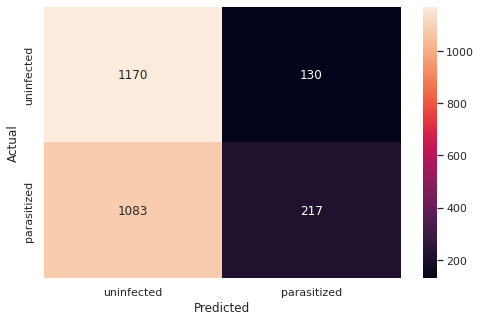





 Train and Validation Accuracy


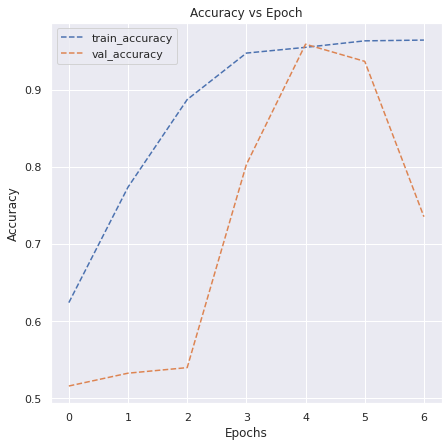

In [ ]:
model23 = ModelWithLeakyReluBatchNormalization(hsvAugmentedData, 'Model With Leaky Relu & Batch Normalization | HSV data | Data augmentation')
model23.execute()

#### Observations for Model With Leaky Relu & Batch Normalization | HSV data | Data augmentation
- Very low accuracy
- Very low recall score for class 1
- Model not useful 


## Model With Transfer Learning using VGG16

In [ ]:
class ModelWithTransferLearningVGG16(AbstractModel):
    def __init__(self, modelData, name):
        self.model = Sequential()
        self.name = name
        AbstractModel.__init__(self, self.model, modelData)

    def define_model(self):
        vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
        vgg.summary()
        transfer_layer = vgg.get_layer('block5_pool')
        vgg.trainable=False
        x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
        x = Dense(256, activation='relu')(x)

        # Similarly add a dense layer with 128 neurons
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)

        # Add a dense layer with 64 neurons
        x = Dense(64, activation='relu')(x)
        x = BatchNormalization()(x)
        pred = Dense(len(self.modelData.classifiers), activation='softmax')(x)

        self.model = Model(vgg.input, pred)

###  Model With Transfer Learning VGG16 | RGB data

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

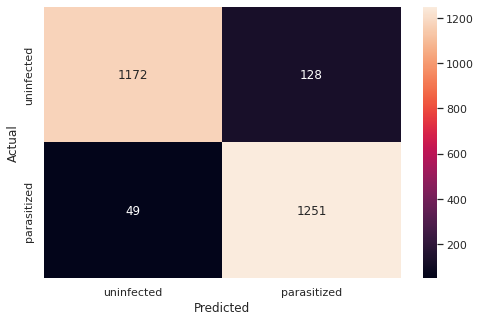





 Train and Validation Accuracy


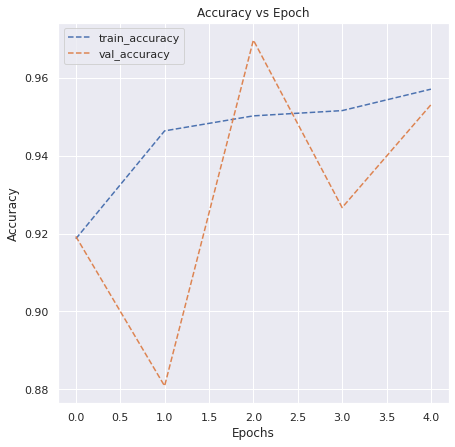

In [ ]:
model30 = ModelWithTransferLearningVGG16(rgbData, 'Model With Transfer Learning VGG16 | RGB data')
model30.execute()

#### Observations for Model With Transfer Learning VGG16 | RGB data
- This model has got a moderate accuracy of 0.93 which is lower some of the other models.
- Recall score for class 1 is 0.96, which is lower than some other model.
- Validation accuracy line is getting closer to training accuracy line after epochs=3.5.


### Model With Transfer Learning VGG16 | RGB data | Data augmentation

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

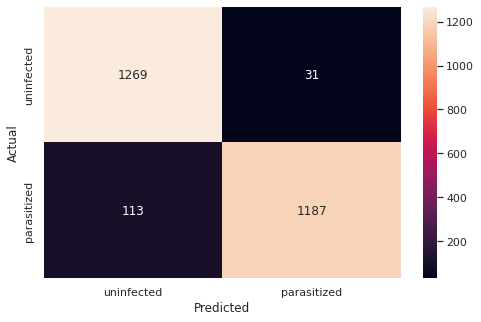





 Train and Validation Accuracy


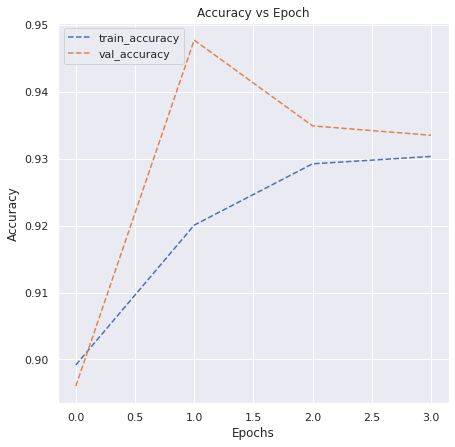

In [ ]:
model31 = ModelWithTransferLearningVGG16(rgbAugmentedData, 'Model With Transfer Learning VGG16 | RGB data | Data augmentation')
model31.execute()

#### Observations for Model With Transfer Learning VGG16 | RGB data | Data augmentation
- This model has got a moderate accuracy of 0.94 which is lower some of the other models.
- Recall score for class 1 is 0.91, which is lower than some other models.
- Validation accuracy line is getting closer to training accuracy line after epochs=2.


### Model With Transfer Learning VGG16 | HSV data

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

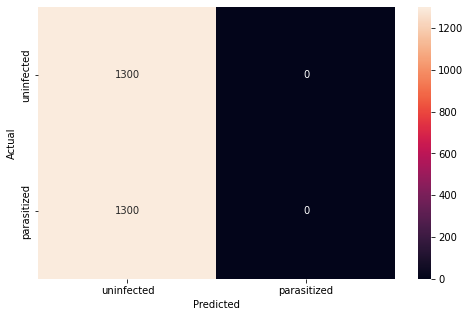





 Train and Validation Accuracy


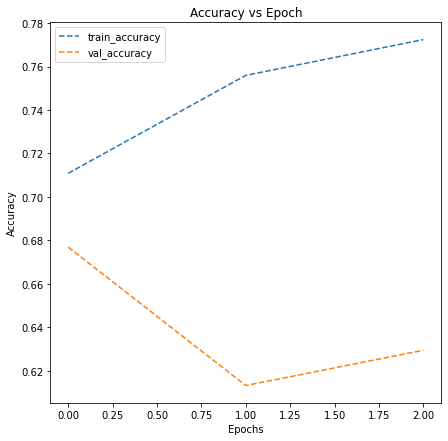

In [ ]:
model32 = ModelWithTransferLearningVGG16(hsvData, 'Model With Transfer Learning VGG16 | HSV data')
model32.execute()

#### Observations for Model With Transfer Learning VGG16 | HSV data
- Very low accuracy
- Very low recall score for class 1
- Model not useful 


### Model With Transfer Learning VGG16 | HSV data | Data augmentation

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

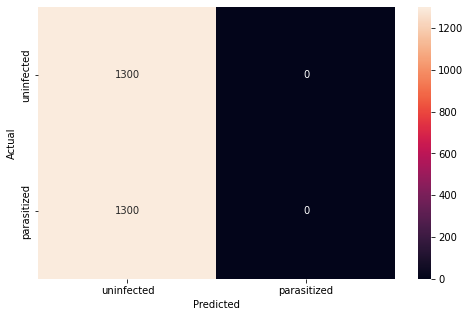





 Train and Validation Accuracy


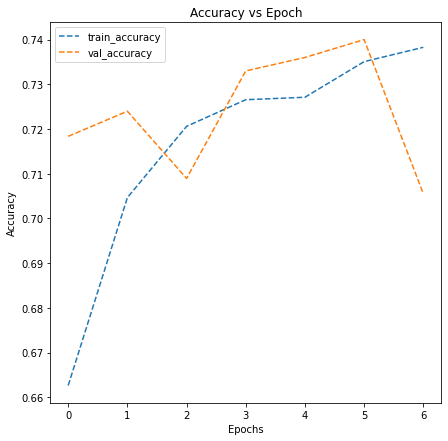

In [ ]:
model33 = ModelWithTransferLearningVGG16(hsvAugmentedData, 'Model With Transfer Learning VGG16 | HSV data | Data augmentation')
model33.execute()

#### Observations for Model With Transfer Learning VGG16 | HSV data | Data augmentation
- Very low accuracy
- Very low recall score for class 1
- Model not useful 


## Creating model data objects referening data with images having bigger size of size 75x75

- Next we are going to use transfer learning using Inception V3 model
- Minimum image size required for Inception V3 model is 75x75

In [ ]:
rgbData_increasedSize = RgbData(data, is_increased_size_required = True)
rgbAugmentedData_increasedSize = RgbAugmentedData(data, is_increased_size_required = True)
hsvData_increasedSize = HsvData(data, is_increased_size_required = True)
hsvAugmentedData_increasedSize = HsvAugmentedData(data, is_increased_size_required = True)

## Model With Transfer Learning using Inception V3

- Minimum image size required for Inception V3 model is 75x75

In [ ]:
class ModelWithTransferLearningInceptionV3(AbstractModel):
    def __init__(self, modelData, name):
        self.model = Sequential()
        self.name = name
        AbstractModel.__init__(self, self.model, modelData)

    def define_model(self):
        inceptionv3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(75,75,3))
        inceptionv3.summary()

        last_layer = inceptionv3.layers[-1]
        
        x = Flatten()(last_layer.output) 
        x = Dense(256, activation='relu')(x)

        # Similarly add a dense layer with 128 neurons
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        
        # Add a dense layer with 64 neurons
        x = Dense(64, activation='relu')(x)
        x = BatchNormalization()(x)
        pred = Dense(len(self.modelData.classifiers), activation='softmax')(x)

        self.model = Model(inceptionv3.input, pred)

### Model With Transfer Learning Inception V3 | RGB data

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activatio

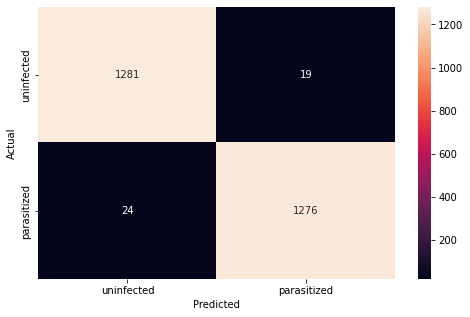





 Train and Validation Accuracy


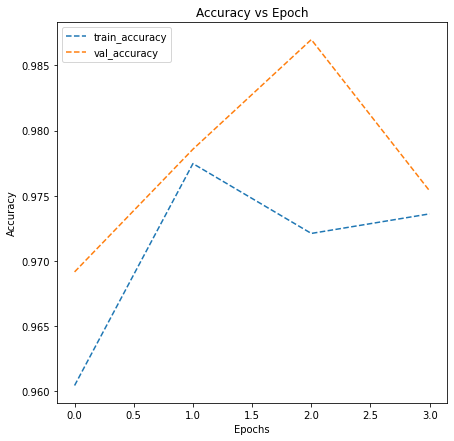

In [ ]:
model40 = ModelWithTransferLearningInceptionV3(rgbData_increasedSize, 'Model With Transfer Learning Inception V3 | RGB data')
model40.execute()

#### Observations for Model With Transfer Learning Inception V3 | RGB data
- This model has high accuracy of 0.98
- Recall for class 1 is 0.99, which is also very high, and good for determining false negative.
- Validation accuracy line gets better with growing epochs.
- Though the model is very good, there are two models which are better than this one.


### Model With Transfer Learning Inception V3 | RGB data | Data augmentation

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

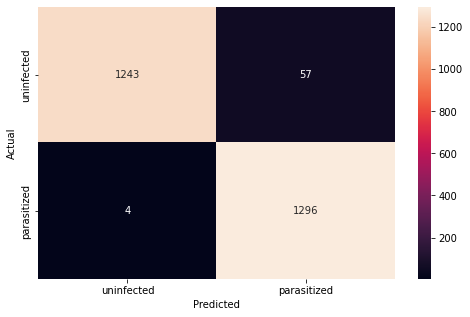





 Train and Validation Accuracy


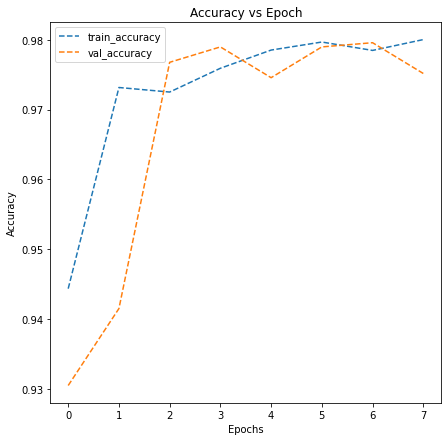

In [ ]:
model41 = ModelWithTransferLearningInceptionV3(rgbAugmentedData_increasedSize, 'Model With Transfer Learning Inception V3 | RGB data | Data augmentation')
model41.execute()

#### Observations for Model With Transfer Learning Inception V3 | RGB data | Data augmentation
- This is the best performing model amongst all the models.
- Very high accuracy of 0.98
- Perfect recall score of 1.00. Out of 1300, only 4 are false negative.
- Validation accuracy line is running very close to the training accuracy line after epochs = 2.


### Model With Transfer Learning Inception V3 | HSV data

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

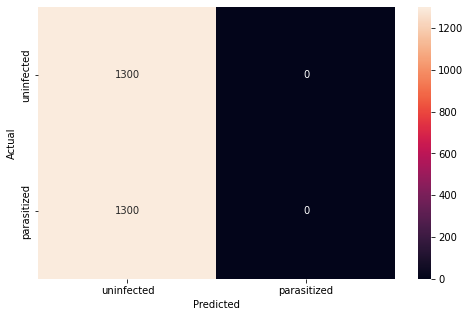





 Train and Validation Accuracy


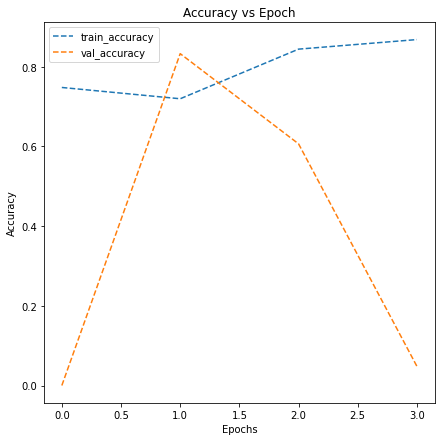

In [ ]:
model42 = ModelWithTransferLearningInceptionV3(hsvData_increasedSize, 'Model With Transfer Learning Inception V3 | HSV data')
model42.execute()

#### Observations for Model With Transfer Learning Inception V3 | HSV data
- Very low accuracy
- Very low recall score for class 1
- Model not useful 


### Model With Transfer Learning Inception V3 | HSV data | Data augmentation

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

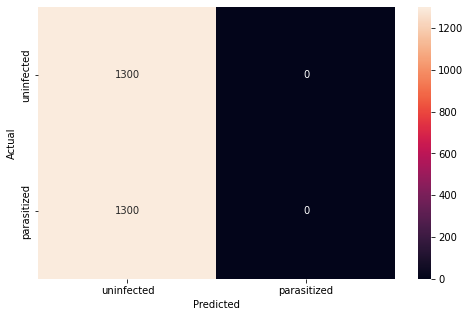





 Train and Validation Accuracy


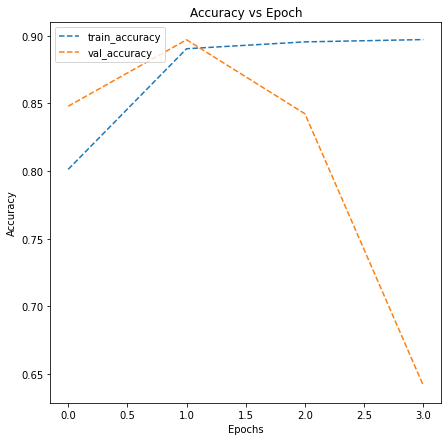

In [ ]:
model43 = ModelWithTransferLearningInceptionV3(hsvAugmentedData_increasedSize, 'Model With Transfer Learning Inception V3 | HSV data | Data augmentation')
model43.execute()

#### Observations for Model With Transfer Learning Inception V3 | HSV data | Data augmentation
- Very low accuracy
- Very low recall score for class 1
- Model not useful 


## Measures of success for the models

- Accuracy plot for checking validation accuracy vs training accuracy and see how close those plots are
- Confusion matrix and calculating precision, recall and f1 score.
  - We in our scenario would want to make sure that we are not depriving anyone from the treatment if they are infected. So, we should <font color='red'>minimize False Negatives</font>
  - To minimize false negative, we shold look for <font color='red'>optimizing 'Recall' score</font>. Higher the recall score, better the model will be for ruling out false negatives.

## Comparison of different models

![model-comparison]( 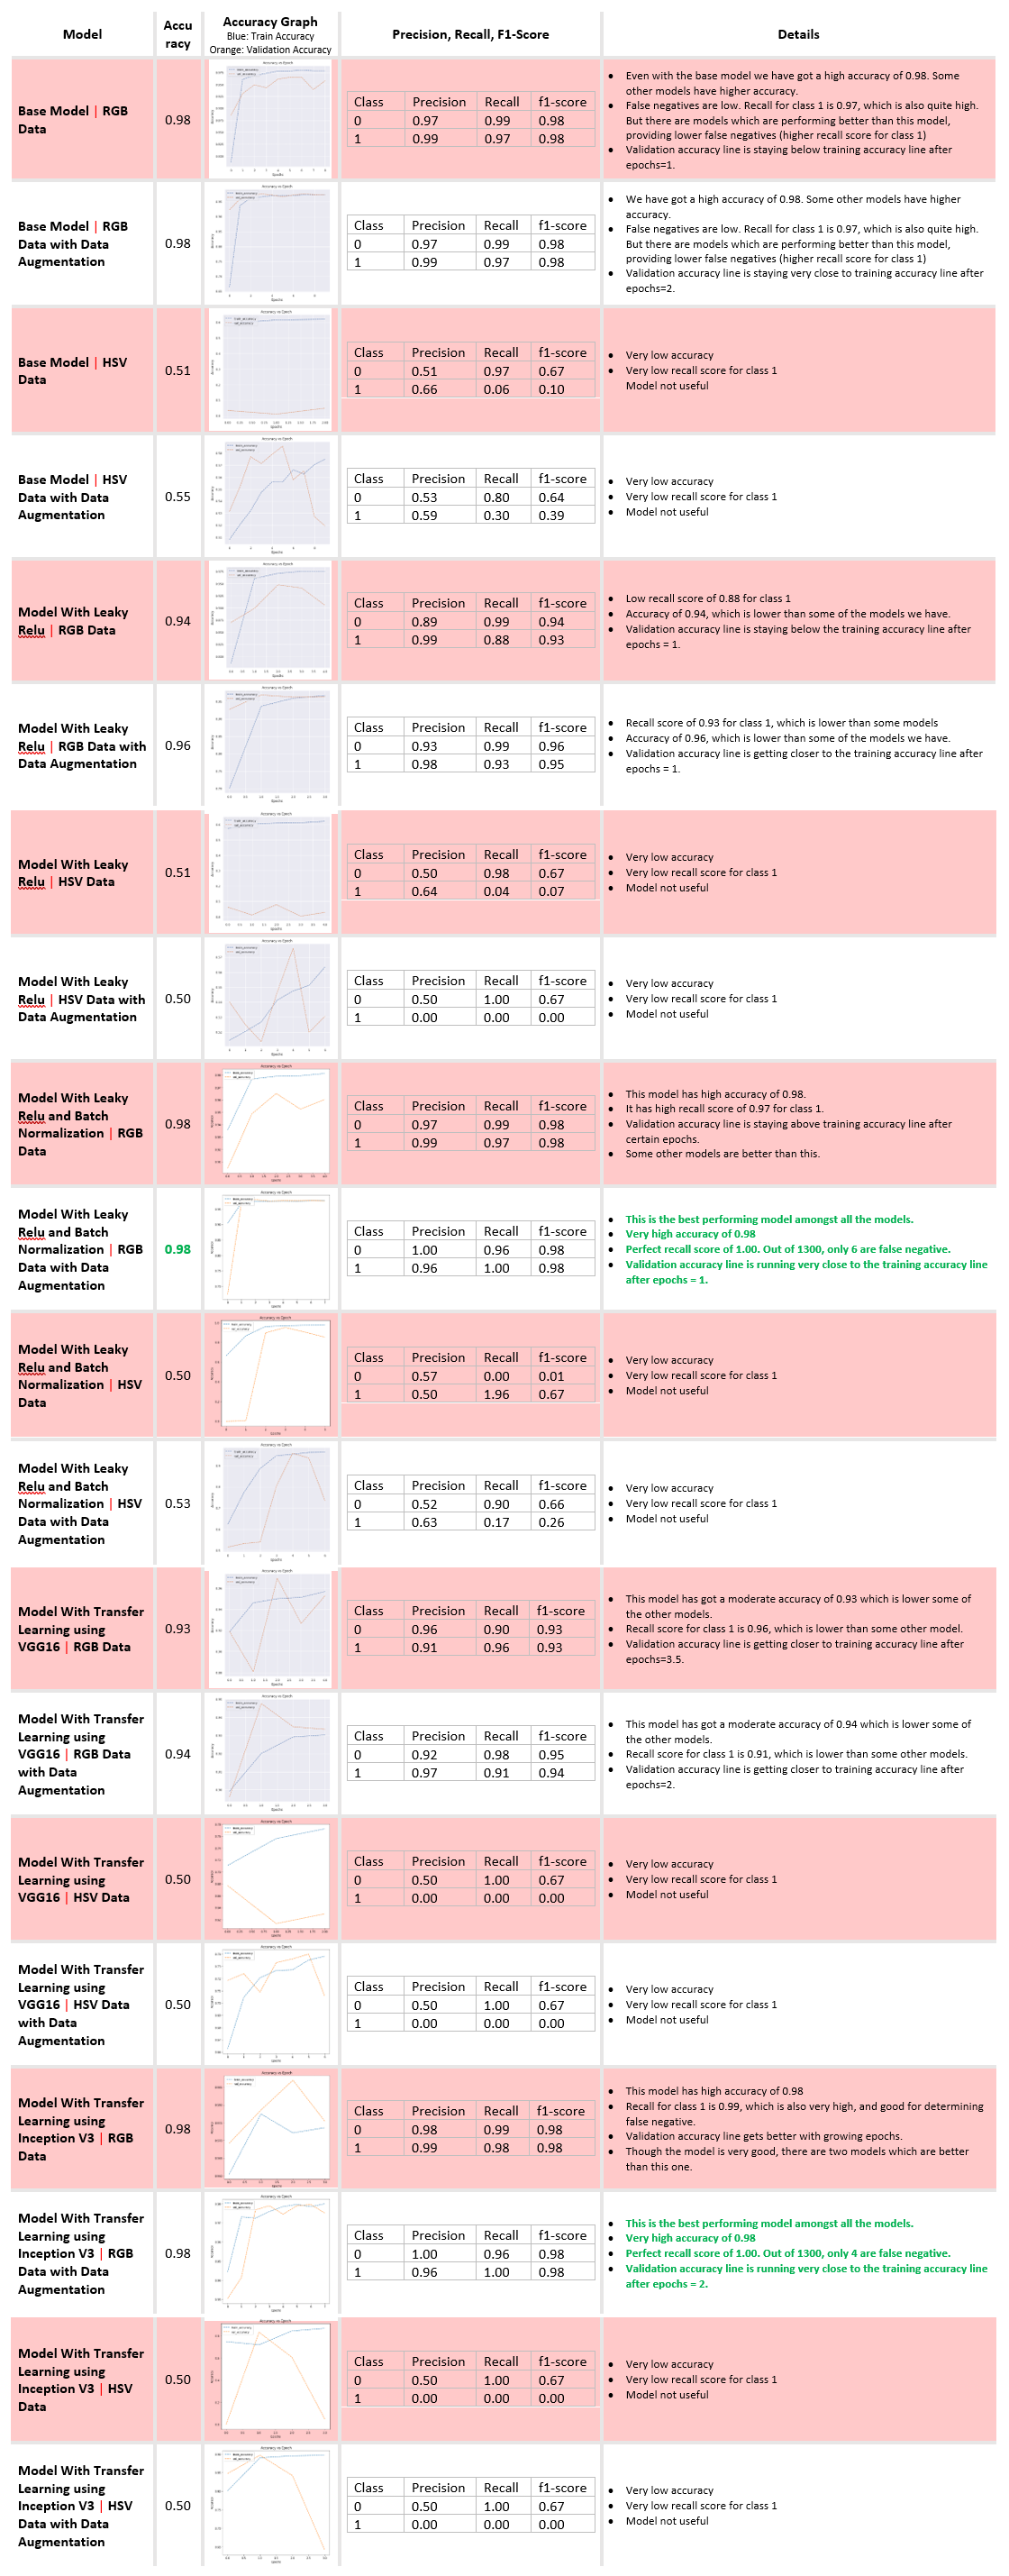)



### Some observations:

- HSV data is not very useful it seems, so goign forward we can drop that data
- RGB with data augmentation on different models performed better

## Best model amonst all the above listed models

![twobest]( 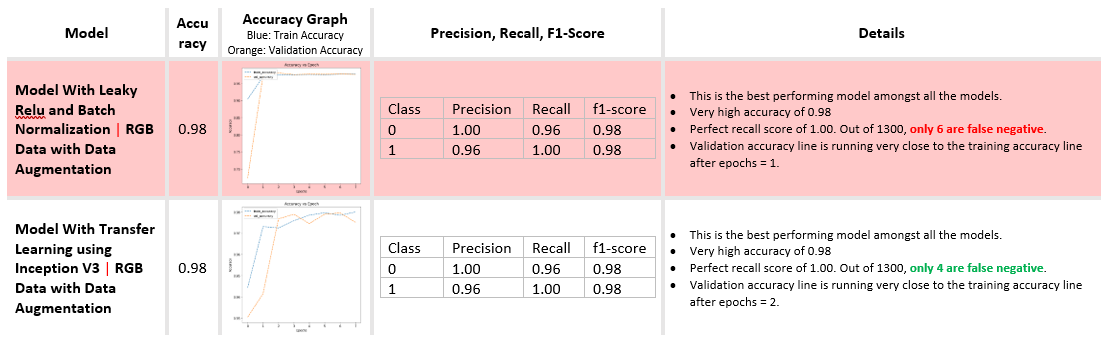)

- Both these models have exactly same scores.
- They have recall score of 1.0 (which implies there are very low false negatives)

### Difference between the models:
- Very very small difference in number of false negatives on test data (of 1300 images):
    - 6 false negatives for "Model With Leaky Relu and Batch Normalization | RGB Data with Data Augmentation"
    - 4 false negatives for "Model With Transfer Learning using Inception V3 | RGB Data with Data Augmentation"
- Cost
    - Model with transfer learning using inception v3 takes much more GPU and time - thus it is costlier.
    
## Recommended model between the above two
- As false negatives can be mission critical to patients life, so even 4 false negatives over 6 false negatives - we should prefer the model "Model With Transfer Learning using Inception V3 | RGB Data with Data Augmentation"
- We should still keep an eye on cost. As new data comes in, we should re-evalute the performance of both these models and then again take a decision

## Appendix

### Complete Class diagram for the python solution

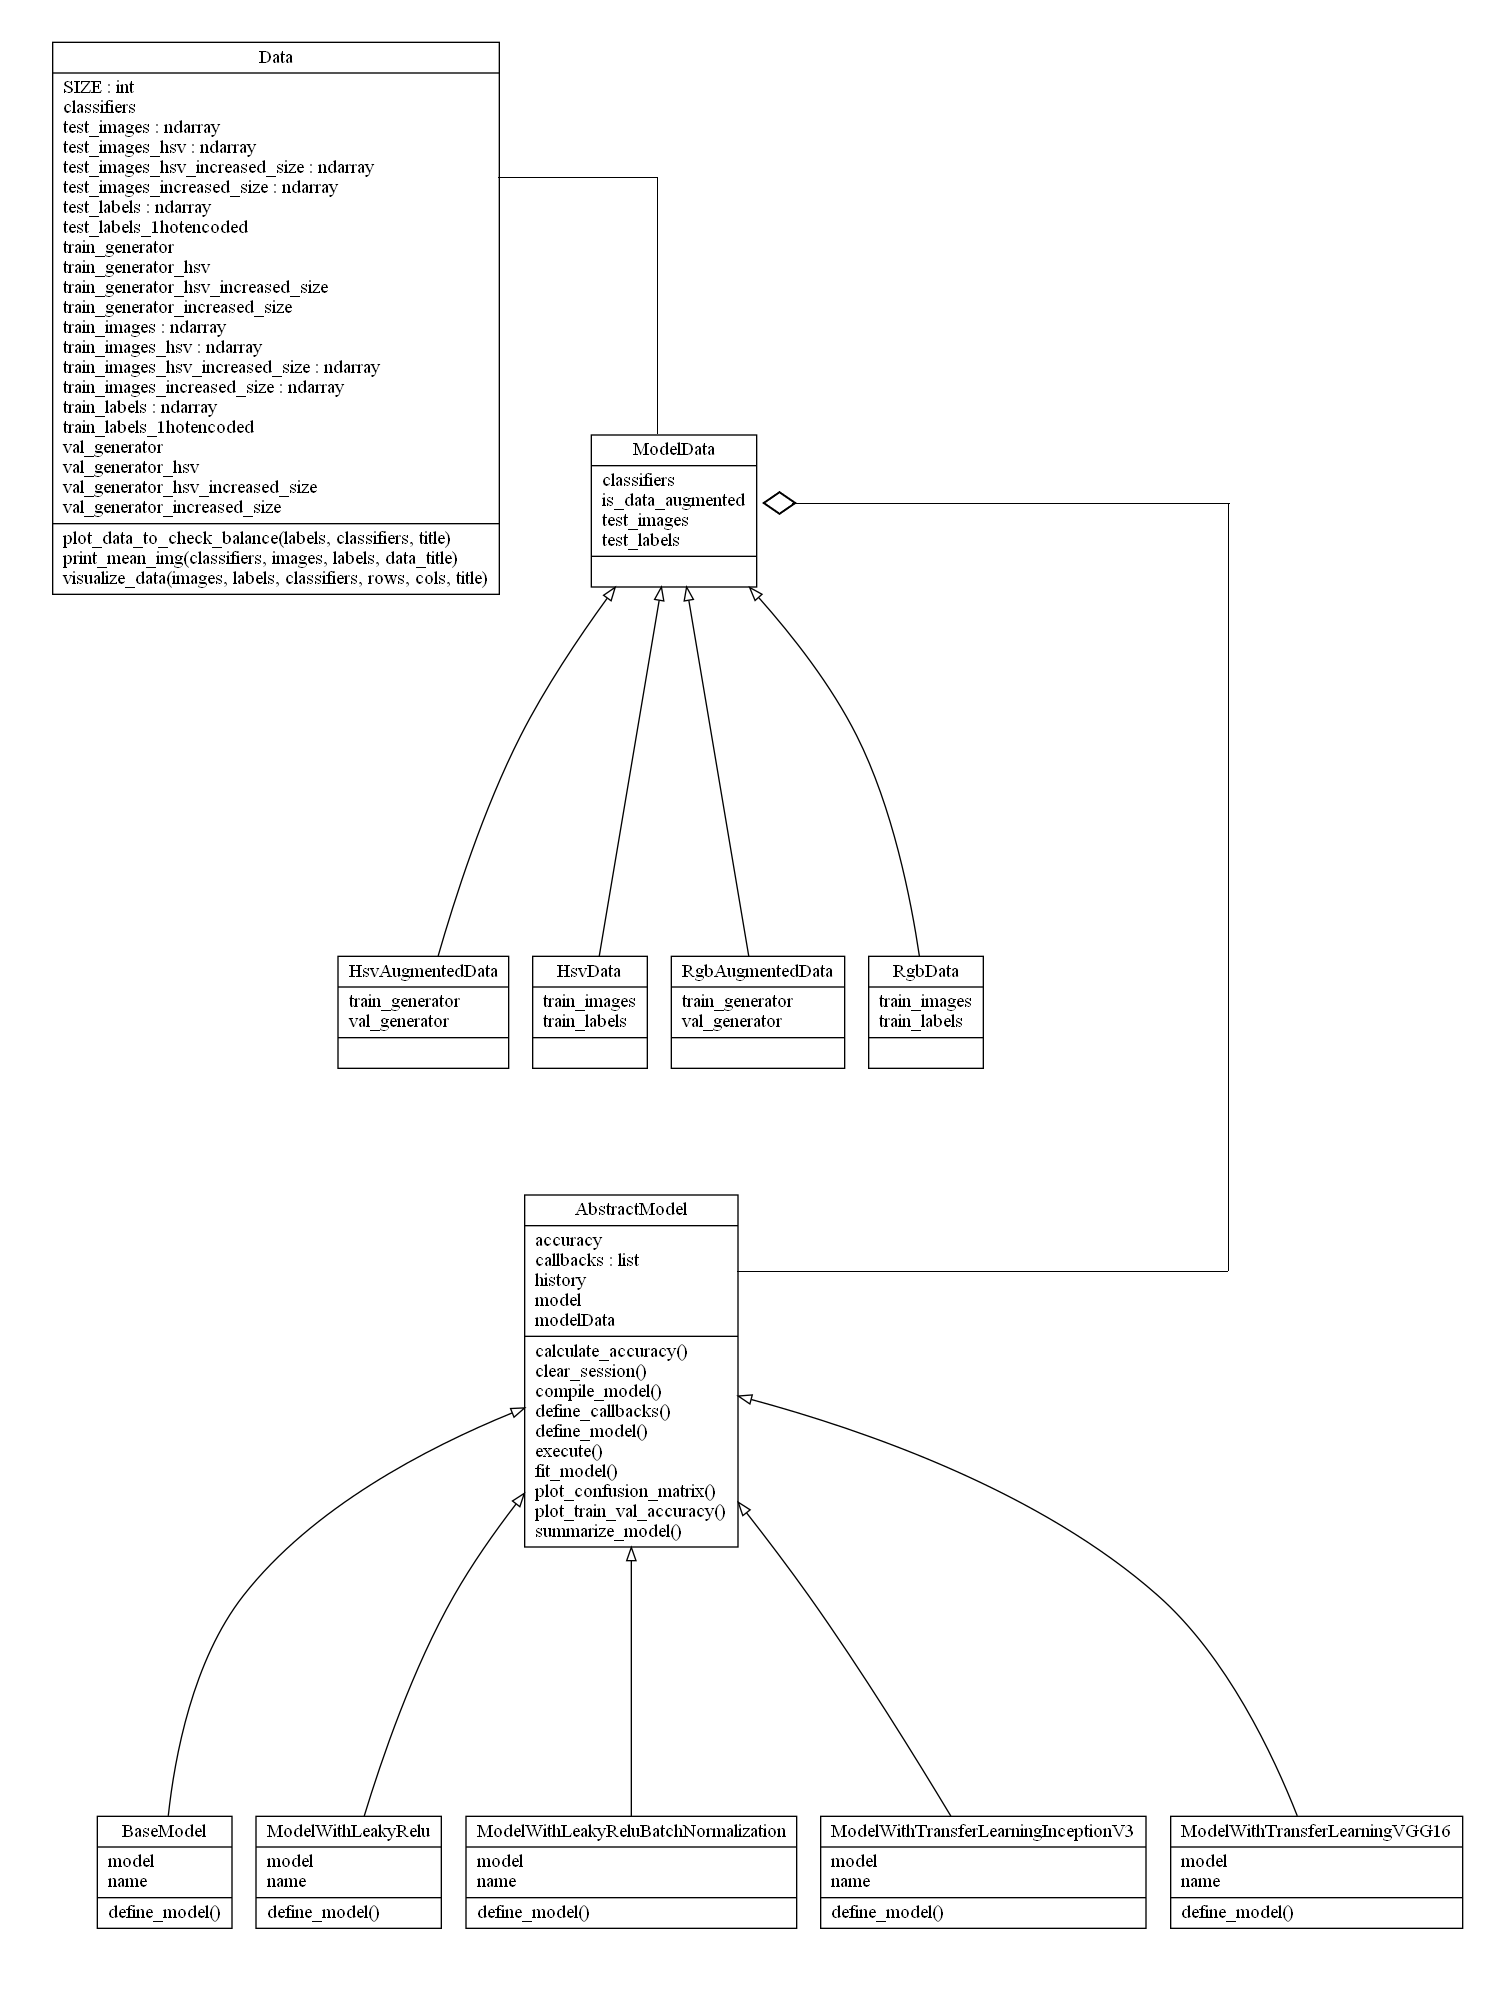
